# CI coverage, length and bias
For event related design. 

In [15]:
# Directories of the data for different scenario's
DATAwd <- list(
  'Take[8mmBox10]' = "/Volumes/2_TB_WD_Elements_10B8_Han/PhD/IBMAvsGLM/Results/Cambridge/ThirdLevel/8mm/boxcar10",
  'Take[8mmEvent2]' = "/Volumes/2_TB_WD_Elements_10B8_Han/PhD/IBMAvsGLM/Results/Cambridge/ThirdLevel/8mm/event2"
	)
NUMDATAwd <- length(DATAwd)
currentWD <- 2

# Number of conficence intervals
CIs <- c('MA-weightVar','GLM-t')
NumCI <- length(CIs)

# Number of executed runs
nruns.tmp <- matrix(c(
                1,2500,
                2,500
              ), ncol=2, byrow=TRUE)
nruns <- nruns.tmp[currentWD,2]


# Number of subjects and studies
nsub <- 20
nstud <- 5

# Dimension of brain
DIM <- c(91,109,91)

# True value
trueVal <- 0

# Load in libraries
library(oro.nifti)
library(dplyr)
library(lattice)
library(grDevices)
library(ggplot2)
library(data.table)
library(gridExtra)

# Function to count the number of instances in which true value is between lower and upper CI.
indicator <- function(UPPER, LOWER, trueval){
  IND <- trueval >= LOWER & trueval <= UPPER
  IND[is.na(IND)] <- 0
  return(IND)
}

# Funtion to count the number of recorded values
counting <- function(UPPER, LOWER){
  count <- (!is.na(UPPER) & !is.na(LOWER))
  return(count)
}

##
###############
### Data Wrangling
###############
##

######################################################
# First we create a universal mask over all iterations
######################################################

# Set warnings off
# options(warn = -1)

# Vector to check progress
CheckProgr <- floor(seq(1,nruns,length.out=10))

# Vector of simulations where we have a missing mask
missingMask <- c()

# Do you want to make an universal mask again?
WRITEMASK <- FALSE
if(isTRUE(WRITEMASK)){
  # Vector with all masks in it
  AllMask <- c()

  # Load in the masks
  for(i in 1:nruns){
    # Print progress
    if(i %in% CheckProgr) print(paste('LOADING MASKS. NOW AT ', (i/nruns)*100, '%', sep = ''))

    # Try reading in mask, then go to one column and convert to data frame.
    CheckMask <- try(readNIfTI(paste(DATAwd[[currentWD]], '/', i,'/mask.nii', sep = ''))[,,,1] %>%
              matrix(.,ncol = 1) %>% data.frame(), silent = TRUE)
      # If there is no mask, skip iteration
      if(class(CheckMask) == "try-error"){ missingMask <- c(missingMask, i); next}

      # Some masks are broken: if all values are zero: REPORT
      if(all(CheckMask == 0)){print(paste("CHECK MASK AT ITERATION ", i, sep = "")); next}

    # Bind the masks of all iterations together
    AllMask <- bind_cols(AllMask, CheckMask)
    rm(CheckMask)
  }

  # Take product to have universal mask
  UnivMask <- apply(AllMask, 1, prod)

  # Better write this to folder
  niftiimage <- nifti(img=array(UnivMask, dim = DIM),dim=DIM)
  writeNIfTI(niftiimage,filename=paste(DATAwd[[currentWD]],'/universalMask',sep=''),gzipped=FALSE)
}
if(isTRUE(!WRITEMASK)){
  # Read in mask
  UnivMask <- readNIfTI(paste(DATAwd[[currentWD]],'/universalMask.nii', sep = ''))[,,] %>%
            matrix(.,ncol = 1)
}


In [16]:
# Load the naming structure of the data
load(paste(paste(DATAwd[['Take[8mmBox10]']], '/1/ObjectsRestMAvsGLM_1.RData',sep=''))); objects <- names(ObjectsRestMAvsGLM); rm(ObjectsRestMAvsGLM)
OBJ.ID <- c(rep(objects[!objects %in% c("STHEDGE","STWEIGHTS")], each=prod(DIM)), rep(c("STHEDGE","STWEIGHTS"), each=c(prod(DIM)*nstud)))

objects.CI <- objects[grepl(c('upper'), objects) | grepl(c('lower'), objects)]


In [17]:
# Pre-define the CI coverage and length vectors in which we sum the values
# After running nruns, divide by amount of obtained runs.
# For bias, we work with VAR(X) = E(X**2) - E(X)**2 and a vector in which we sum the bias.
# Hence, we need to sum X**2 and X in a separate vector.
summed.coverage.IBMA <- summed.coverage.GLM <-
summed.length.IBMA <- summed.length.GLM <-
summed.X.IBMA <- summed.X.GLM <-
summed.X2.IBMA <- summed.X2.GLM <-
    array(0,dim=c(sum(UnivMask == 1),1))

# Keeping count of amount of values
counterMA <- counterGLM <- 0

# Load in the data
t1 <- Sys.time()
for(i in 1:nruns){
  if(i %in% CheckProgr) print(paste('PROCESSING. NOW AT ', (i/nruns)*100, '%', sep = ''))

    # CI coverage: loop over the two procedures
    for(p in 1:2){
      objUP <- objects.CI[grepl(c('upper'), objects.CI)][p] %>% gsub(".", "_",.,fixed = TRUE)
      objLOW <- objects.CI[grepl(c('lower'), objects.CI)][p] %>% gsub(".", "_",.,fixed = TRUE)

      UP <- try(fread(file = paste(DATAwd[[currentWD]], '/', i, '/', objUP, '.txt', sep = ''), header = FALSE) %>% filter(., UnivMask == 1), silent = TRUE)
              if(class(UP) == "try-error"){print(paste('Missing data in iteration ', i, sep = '')); next}
      LOW <- fread(file = paste(DATAwd[[currentWD]], '/',i, '/', objLOW, '.txt', sep = ''), header = FALSE) %>% filter(., UnivMask == 1)
      if(grepl('MA', x = objUP)){
        # CI coverage: add when true value in CI
        summed.coverage.IBMA[,1] <- summed.coverage.IBMA[,1] +
          indicator(UPPER = UP, LOWER = LOW, trueval = 0)
        # CI length: sum the length
        summed.length.IBMA[,1] <- summed.length.IBMA[,1] + as.matrix(UP - LOW)
        # Add one to the count (if data is available)
        counterMA <- counterMA + counting(UPPER = UP, LOWER = LOW)
      }else{
        # GLM procedure: CI coverage
        summed.coverage.GLM[,1] <- summed.coverage.GLM[,1] +
          indicator(UPPER = UP, LOWER = LOW, trueval = 0)
        # CI length: sum the length
        summed.length.GLM[,1] <- summed.length.GLM[,1] + as.matrix(UP - LOW)
        # Count
        counterGLM <- counterGLM + counting(UPPER = UP, LOWER = LOW)
      }
      rm(objUP, objLOW, UP, LOW)
    }

    # Standardized bias: read in weighted average / cope
    WAVG <- fread(file = paste(DATAwd[[currentWD]], '/', i, '/MA_WeightedAvg.txt', sep = ''), header = FALSE) %>% filter(., UnivMask == 1)
    GLMCOPE <- fread(file = paste(DATAwd[[currentWD]], '/', i, '/GLM_COPE', '.txt', sep = ''), header = FALSE) %>% filter(., UnivMask == 1)
    # Sum X
    summed.X.IBMA[,1] <- summed.X.IBMA[,1] + as.matrix(WAVG)
    summed.X.GLM[,1] <- summed.X.GLM[,1] + as.matrix(GLMCOPE)
    # Sum X**2
    summed.X2.IBMA[,1] <- summed.X2.IBMA[,1] + as.matrix(WAVG ** 2)
    summed.X2.GLM[,1] <- summed.X2.GLM[,1] + as.matrix(GLMCOPE ** 2)

}
Sys.time() - t1


[1] "PROCESSING. NOW AT 0.2%"
[1] "PROCESSING. NOW AT 11.2%"
[1] "PROCESSING. NOW AT 22.2%"
[1] "PROCESSING. NOW AT 33.4%"
[1] "PROCESSING. NOW AT 44.4%"
[1] "PROCESSING. NOW AT 55.6%"
[1] "PROCESSING. NOW AT 66.6%"
[1] "PROCESSING. NOW AT 77.8%"
[1] "PROCESSING. NOW AT 88.8%"
[1] "PROCESSING. NOW AT 100%"


Time difference of 7.818478 mins

In [18]:
# Calculate the average (over nsim) CI coverage, length and bias
Coverage.IBMA <- summed.coverage.IBMA/counterMA
Coverage.GLM <- summed.coverage.GLM/counterGLM

Length.IBMA <- summed.length.IBMA/counterMA
Length.GLM <- summed.length.GLM/counterGLM

# Formula: Var(X) = E(X**2) - [E(X)]**2
  # E(X**2) = sum(X**2) / n
  # E(X) = sum(X) / n
  # \hat{var(X)} = var(X) * (N / N-1)
  # \hat{SD} = sqrt(\hat{var(X)})
samplingSD.IBMA <- sqrt(((summed.X2.IBMA/(counterMA)) - ((summed.X.IBMA/counterMA)**2)) * (counterMA / (counterMA - 1)))
samplingSD.GLM <- sqrt(((summed.X2.GLM/(counterGLM)) - ((summed.X.GLM/counterGLM)**2)) * (counterGLM / (counterGLM - 1)))

# Standardized bias: true beta = 0
Bias.IBMA <- ((summed.X.IBMA / counterMA) - 0) / samplingSD.IBMA
Bias.GLM <- ((summed.X.GLM / counterGLM) - 0) / samplingSD.GLM

In [19]:
# Heatmap of the coverages
emptBrainIBMA <- emptBrainGLM <- array(NA, dim = prod(DIM))
emptBrainIBMA[UnivMask == 1] <- c(summed.coverage.IBMA/counterMA)
emptBrainGLM[UnivMask == 1] <- c(summed.coverage.GLM/counterGLM)

LevelPlotMACoV <- levelplot(array(emptBrainIBMA, dim = DIM)[,,40], col.regions = topo.colors,
                	xlim=c(0,DIM[1]),ylim=c(0,DIM[2]), xlab = 'x', ylab = 'y',
                  main = 'CI coverage meta-analysis')
LevelPlotGLMCoV <- levelplot(array(emptBrainGLM, dim = DIM)[,,40], col.regions = topo.colors,
                  xlim=c(0,DIM[1]),ylim=c(0,DIM[2]), xlab = 'x', ylab = 'y',
                  main = 'CI coverage GLM')

# Bias
emptBrainIBMA <- emptBrainGLM <- array(NA, dim = prod(DIM))
emptBrainIBMA[UnivMask == 1] <- Bias.IBMA
emptBrainGLM[UnivMask == 1] <- Bias.GLM
LevelPlotMABias <- levelplot(array(emptBrainIBMA, dim = DIM)[,,40], col.regions = topo.colors,
                	xlim=c(0,DIM[1]),ylim=c(0,DIM[2]), xlab = 'x', ylab = 'y',
                  main = 'Standardized bias Meta-Analysis')
LevelPlotGLMBias <- levelplot(array(emptBrainGLM, dim = DIM)[,,40], col.regions = topo.colors,
                  xlim=c(0,DIM[1]),ylim=c(0,DIM[2]), xlab = 'x', ylab = 'y',
                  main = 'Standardized bias GLM')
DifferenceBias <- levelplot(array(emptBrainIBMA - emptBrainGLM, dim = DIM)[,,c(36:46)], col.regions = topo.colors,
                	xlim=c(0,DIM[1]),ylim=c(0,DIM[2]), xlab = 'x', ylab = 'y',
                  main = 'Bias MA - GLM')

# CI length
emptBrainIBMA <- emptBrainGLM <- array(NA, dim = prod(DIM))
emptBrainIBMA[UnivMask == 1] <- Length.IBMA
emptBrainGLM[UnivMask == 1] <- Length.GLM
LevelPlotMACL <- levelplot(array(emptBrainIBMA, dim = DIM)[,,40], col.regions = topo.colors,
                	xlim=c(0,DIM[1]),ylim=c(0,DIM[2]), xlab = 'x', ylab = 'y',
                  main = 'CI length Meta-Analysis')
LevelPlotGLMCL <- levelplot(array(emptBrainGLM, dim = DIM)[,,40], col.regions = topo.colors,
                  xlim=c(0,DIM[1]),ylim=c(0,DIM[2]), xlab = 'x', ylab = 'y',
                  main = 'CI length GLM')

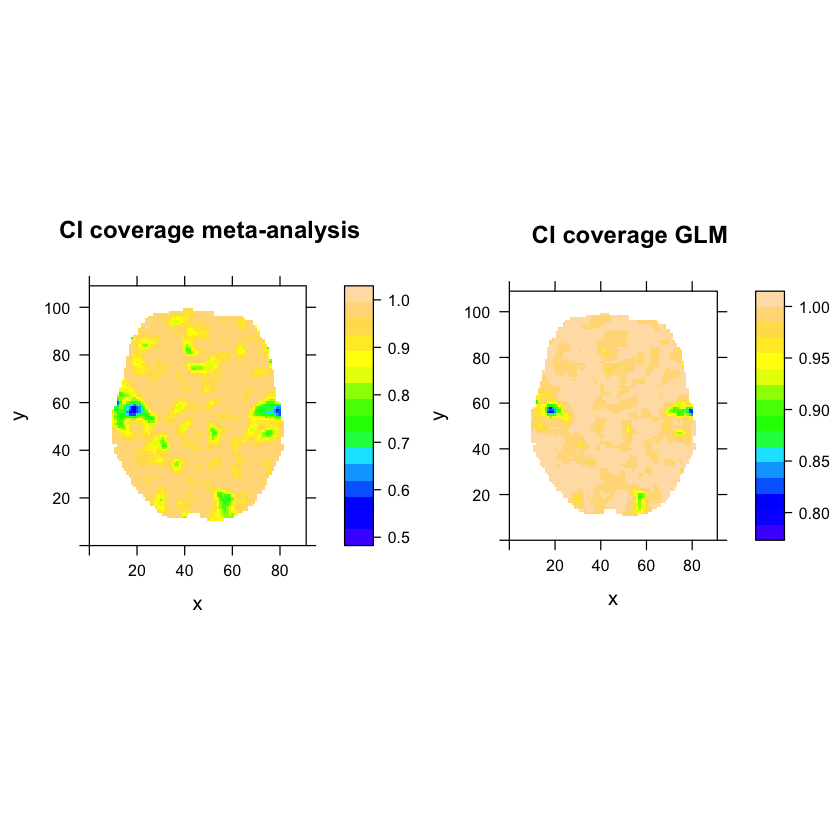

In [20]:
grid.arrange(LevelPlotMACoV,LevelPlotGLMCoV, ncol = 2)

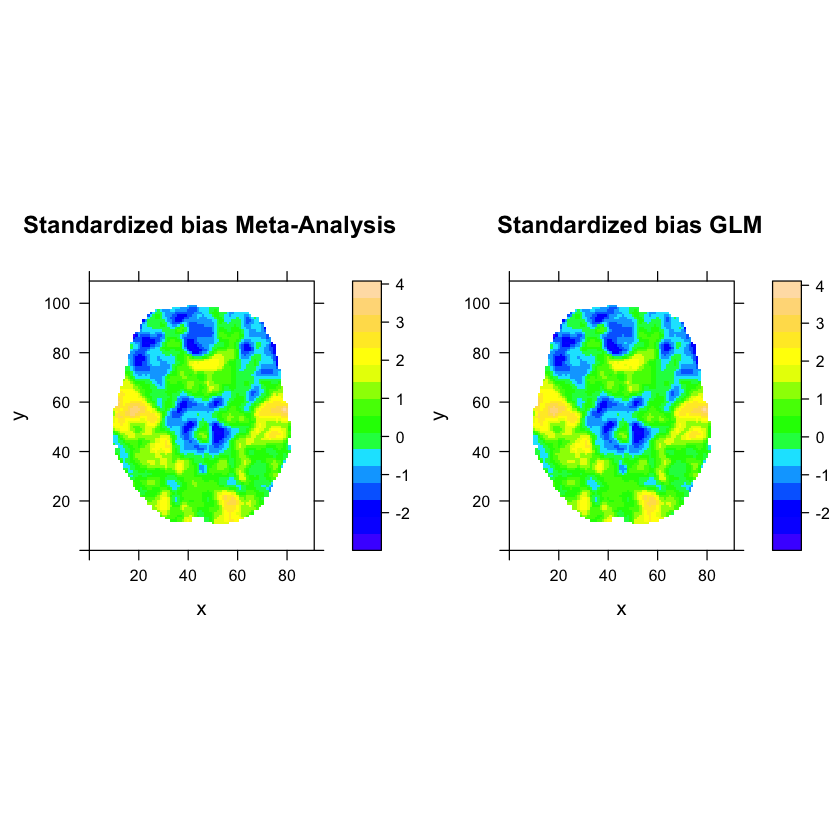

In [21]:
grid.arrange(LevelPlotMABias,LevelPlotGLMBias, ncol = 2)

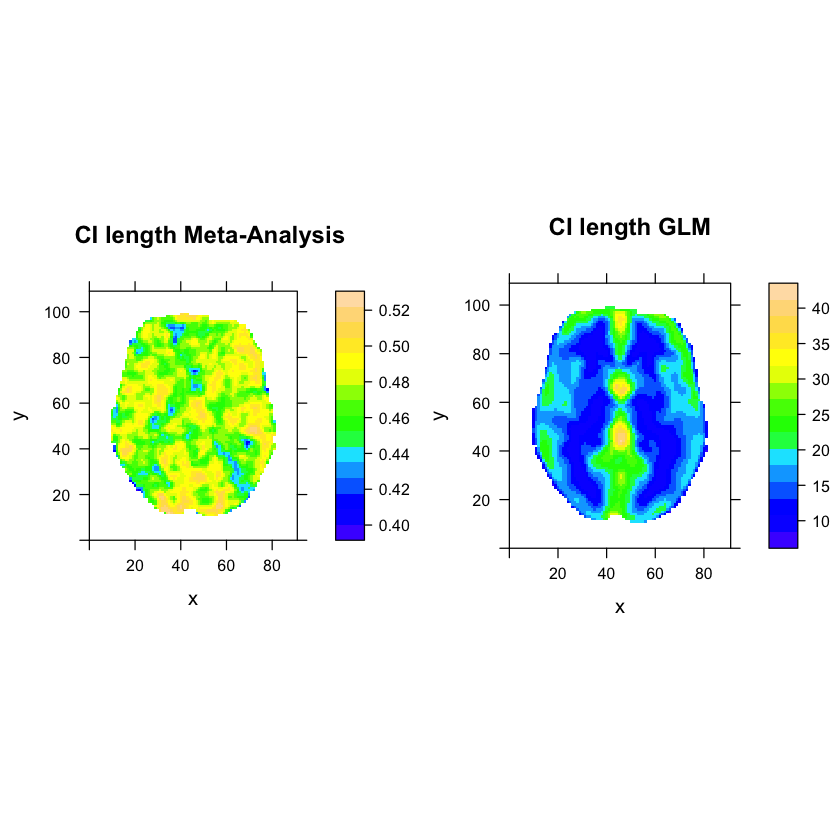

In [22]:
grid.arrange(LevelPlotMACL,LevelPlotGLMCL, ncol = 2)